In [6]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
import trireg
reload(trireg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ensemble/')
import stacking
reload(stacking)

sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/neighbors/')
import rpfnn
reload(rpfnn)
import ann
reload(ann)

import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import transformers as tforms
reload(tforms)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold, train_test_split

from sklearn.base import clone

from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.lda import LDA
from sklearn.qda import QDA

from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression

from sklearn.preprocessing import StandardScaler

from collections import Counter
import minirank as mr

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

import cPickle as pickle

from pysofia.compat import RankSVM, RankSVMCV

def wgmean(x, w):
    return np.exp(np.sum(w*np.log(x), axis=1) / np.sum(w, axis=1))

In [2]:
# Load Data
train_pd  = pd.read_pickle('saved/train_pd_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')

fi = np.load('saved/feature_importances.npy')
y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)


In [2]:
# Load Data le instead
# train_pd  = pd.read_pickle('saved/train_pd_l_enc.p')
# test_pd  = pd.read_pickle('saved/test_pd_l_enc.p')

train_pd  = pd.read_pickle('saved/train_pd_le_and_oh_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_le_and_oh_enc.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [2]:
# Load Data binary instead
train_pd  = pd.read_pickle('saved/train_pd_binary_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_binary_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')

y_binned[y_binned==6] = 5

In [3]:
X_tsne2_26 = np.load('saved/X_tsne2_26important.npy')
X_tsne2_26_train = X_tsne2_26[:len(train_pd), :]
X_tsne2_26_test = X_tsne2_26[-len(test_pd):, :]

X_tsne2 = np.load('saved/X_tsne2.npy')
X_tsne2_train = X_tsne2[:len(train_pd), :]
X_tsne2_test = X_tsne2[-len(test_pd):, :]

print X_tsne2_train.shape
print X_tsne2_test.shape
print X_tsne2_26_train.shape
print X_tsne2_26_test.shape

(50999, 2)
(51000, 2)
(50999, 2)
(51000, 2)


In [4]:
train = np.array(train_pd)
test = np.array(test_pd)

X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

try:
    X_train = np.c_[X_train, X_tsne2_26_train]
    X_test = np.c_[X_test, X_tsne2_26_test]
#     X_train = X_tsne2_26_train
#     X_test = X_tsne2_26_test
except:
    pass

holdout = False
if holdout:
    X_train, X_hold, \
    y_train, y_hold, \
    y_binned, y_binned_hold \
    = train_test_split(
        X_train, y_train, y_binned, 
        test_size=0.2, random_state=0)


pipe_x = make_pipeline(
    make_union(
        tforms.IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
#     StandardScaler(),
)
pipe_y = make_pipeline(
    tforms.IdentityTformer(),
#     tforms.BoxCoxTformer(),
#     tforms.LogTformer(),
#     tforms.AnscombeTformer(),
#     tforms.FreemanTukeyTformer(),
#     tforms.ArcsinhTformer(),
#     StandardScaler(),
    
)
pipe_x.fit(np.r_[X_train, X_test])
pipe_y.fit(y_train)

X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
try:
    X_hold = pipe_x.transform(X_hold)
except:
    pass
# y_train = pipe_y.fit_transform(y_train)

# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]
# y_binned = y_binned[:small_n]

print 'y_train', y_train.shape
print 'X_train', X_train.shape
print 'X_test', X_test.shape
try:
    print 'X_hold', X_hold.shape
except:
    pass
print len(np.unique(y_train))
print len(np.unique(y_binned))
print type(X_train[0][0])

y_train (50999,)
X_train (50999, 125)
X_test (51000, 125)
X_hold 50
5
<type 'numpy.float64'>


In [84]:
ord_gaussnb_bin = simple.SimpleOrdinalClassifier(GaussianNB(), n_jobs=-1)
gbm = xgb.XGBRegressor(
    objective="reg:linear",
    n_estimators=600,
    learning_rate=0.005,
#     gamma=0.0,
    max_depth=9,
    min_child_weight=6,
#     max_delta_step=10,
    subsample=0.7,
    colsample_bytree=0.7,
#     scale_pos_weight=1.0,
    base_score=0.5,
    nthread=-1,
    seed=np.random.randint(0,100),
    silent=True,
)

# clfs = [RankSVM(max_iter=1000)]
# clfs = [LinearRegression()]
# clfs = [gbm]
clfs = [Ridge()]


scores = []
scores_base = []
lols = []
n_reps = 1
k = 3
for reps in range(n_reps):
    skf = StratifiedKFold(y_binned, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        
        
#         history = LossHistory()   # for keras
        print 'Fold %d' % ii,
        X_train_k = q[train]
        X_valid_k = q[valid]
        y_train_k = y_train[train]
        y_valid_k = y_train[valid]
        y_train_binned_k = y_binned[train]
        y_valid_binned_k = y_binned[valid]     
        
        
        X_all = np.r_[X_train_k, X_valid_k]
        y_all = np.r_[y_train_k, np.nan*np.ones(len(y_valid_k))]
        
        tic = time()
#         clf.fit(X_train_k, y_train_k)
#         clf.fit(X_all, y_all)

        for clf in clfs:
            clf.fit(X_train_k, pipe_y.transform(y_train_k))
#             clf.fit(X_train_k, y_train_binned_k)
#             clf.fit(X_train_k, y_train_binned_k,
#                    nb_epoch=60, batch_size=1024*16, )
#             clf.fit(X_train_k, y_train_k, 
#                     base0_y=y_train_binned_k,
#                     base1_y=y_train_binned_k,
# #                     base2_y=y_train_binned_k,
#                    )
    
    
        
        # Minirank
#         w, theta = mr.ordinal_logistic_fit(X_train_k, y_train_k, verbose=False,
#                                 solver='TNC')

        
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc,
        tic = time()

        
        
        valid_preds = [clf.predict_weighted(X_valid_k,) 
                       if hasattr(clf, 'predict_weighted') 
                       else clf.predict(X_valid_k)
                       for clf in clfs]
        
#         valid_preds = [clf.predict_weighted(X_valid_k, batch_size=1024*16) 
#                if hasattr(clf, 'predict_weighted') 
#                else clf.predict(X_valid_k)
#                for clf in clfs]
        
        try:
            lol = metrics.normalized_gini(y_valid_k, 
                                          clfs[0].predict_weighted(X_valid_k, geometric=True))
            lols.append(lol)
        except:
            pass

        # Minirank
#         valid_preds = mr.ordinal_logistic_predict(w, theta, X_valid_k)
        
        valid_base_preds = np.mean([clf.predict(X_valid_k) for clf in clfs
                                   ], 
                                   axis=0)

        
        score = [metrics.normalized_gini(y_valid_k, v) for v in valid_preds]
        score_base = metrics.normalized_gini(y_valid_k, valid_base_preds)
        
        toc_pred = time() - tic
        print 'Pred time: %2.3f s\t' % toc_pred, 
        
        print 'Score', score
        print 'Score avg ensemble', score_base
        scores.append(score)
        scores_base.append(score_base)
        
#         break
        
        
print "done"
print 'Score:', np.array(scores).mean(axis=0)
print 'Base Score:', np.array(scores_base).mean()
print 'lol', lols, np.mean(lols)

Fold 0 Train time: 1.404 s	Pred time: 0.295 s	Score [0.328038698049521]
Score avg ensemble 0.32803869805
Fold 1 Train time: 1.411 s	Pred time: 0.292 s	Score [0.31757442121902096]
Score avg ensemble 0.317574421219
Fold 2 Train time: 1.414 s	Pred time: 0.294 s	Score [0.30003639874794225]
Score avg ensemble 0.300036398748
done
Score: [ 0.31521651]
Base Score: 0.315216506005
lol [] nan


In [9]:
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

In [14]:
dump_svmlight_file(X_train, y_train, 'saved/train.svmlight')

In [15]:
X_all = np.r_[X_train, X_test]

In [17]:
dump_svmlight_file(X_all, np.zeros(len(X_all)), 'saved/X_all.svmlight')

(array([ 5081407.,  7292202.,  8151778.,  7961079.,  7241560.,  6197011.,
         4813680.,  3009285.,  1121432.,   129566.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

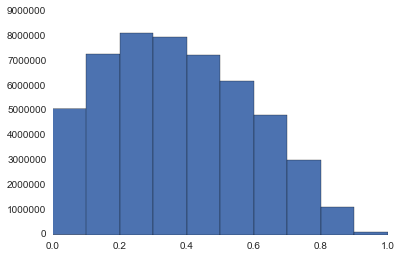

In [46]:
q.shape

(50999, 50)

In [4]:
import os
from subprocess import Popen, call, PIPE
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

def call_stuff(cmd):
    p = Popen(cmd, stdout=PIPE, stderr=PIPE)
    while True:
        line = p.stdout.readline()
        if line != '':
            print line.rstrip()
        else:
            break
    output, err = p.communicate()
    print output
    print err

In [2]:
n_clusters = 2000

In [6]:
fit_call = [
    'sofia-kmeans',
    '--k', str(n_clusters),
    '--init_type', 'optimized_kmeans_pp',
    '--opt_type', 'mini_batch_kmeans', 
    '--mini_batch_size', '100',
    '--iterations', '800', 
    '--objective_after_init',
    '--objective_after_training',
    '--training_file', 'saved/X_all.svmlight',
    '--model_out', 'saved/model_sofia%d'%n_clusters,
]

call_stuff(fit_call)

Time to read training data from saved/X_all.svmlight: 0.72912
Time to initialize cluster centers: 54.0341
Objective function value for initialization: 1.70301e+07
Time to compute objective function: 20.0283
Time to optimize cluster centers: 15.8199
Objective function value for training: 1.21412e+07
Time to compute objective function: 20.2886

Reading data from: saved/X_all.svmlight
Writing model to: saved/model_sofia2000
   Done.
   Done.



In [13]:
map_call = [
    'sofia-kmeans',
    '--model_in', 'saved/model_sofia%d'%n_clusters,
    '--test_file', 'saved/train.svmlight',
    '--cluster_mapping_out', 'saved/mapped%d_train.libsvm'%n_clusters,
    '--cluster_mapping_type', 'rbf_kernel',
    '--cluster_mapping_param', '0.0003',
    '--cluster_mapping_threshold', '0.01',
]

call_stuff(map_call)

Time to read training data from saved/train.svmlight: 0.331031

Reading data from: saved/train.svmlight
Writing cluster mappings to: saved/mapped2000_train.libsvm
   Done.



In [ ]:
# np.save('saved/X_train_1000means.npy', q)

In [5]:

mapped_train, _y = load_svmlight_file('saved/mapped%d_train.libsvm'%n_clusters)
q = mapped_train.todense()


(array([  1628907.,   5668079.,   9077358.,  13035766.,  15994524.,
         17308853.,  16765833.,  13896728.,   7555212.,   1066740.]),
 array([ 0.0129577 ,  0.11166193,  0.21036616,  0.30907039,  0.40777462,
         0.50647885,  0.60518308,  0.70388731,  0.80259154,  0.90129577,  1.        ]),
 <a list of 10 Patch objects>)

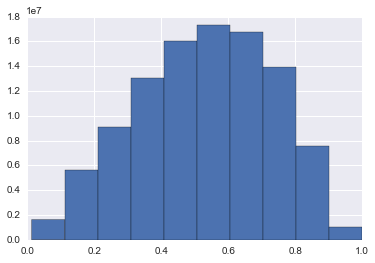

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.hist(np.ravel(q))